In [93]:
# torch modules
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, ToPILImage

# hugging face modules 
from transformers import ViTImageProcessor, ViTForImageClassification, Trainer, TrainingArguments

from datasets import load_dataset

from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Basic Inference

In [94]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

In [95]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [96]:
input = processor(images=image, return_tensors='pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


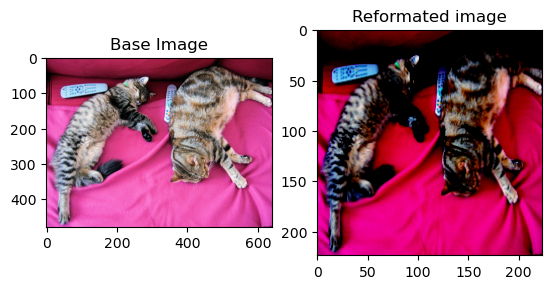

In [97]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
plt.title('Base Image')
bx = fig.add_subplot(1, 2, 2)
plt.title('Reformated image')
ax.imshow(image)
bx.imshow(input['pixel_values'].squeeze(0).permute(1, 2, 0)) 

In [100]:
output = model(**input)
logits = output.logits
predicted_class = logits.argmax(dim=1).item()

print(f'Predicted Class : {model.config.id2label[predicted_class]}')

Predicted Class : Egyptian cat


# Fine Tuning

In [114]:
train_ds, testds = load_dataset("cifar10", split = ["train[:5000]", 'test[:1000]'])
splits = train_ds.train_test_split(test_size=0.1)
trainds, valds = splits['train'], splits['test']

In [125]:
itos = dict((k, v) for k, v in enumerate(train_ds.features['label'].names))
stoi = dict((v, k) for k, v in enumerate(train_ds.features['label'].names))

In [134]:
mean, std = processor.image_mean, processor.image_std
size = processor.size

In [142]:
transform_ = Compose([
    Resize(size['height']),
    ToTensor(),
    Normalize(mean, std)
])

def transform(arg):
    arg['pixels'] = [transform_(image.convert('RGB')) for image in arg['img']]
    return arg

In [143]:
trainds.set_transform(transform)
valds.set_transform(transform)
testds.set_transform(transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


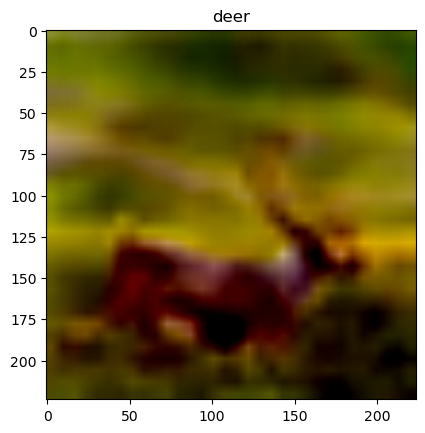

In [161]:
idx = 0
ex = trainds[idx]['pixels']
label = trainds[idx]['label']
plt.title(itos[label])
plt.imshow(ex.permute(1, 2, 0))

In [164]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=10, ignore_mismatched_sizes=True, id2label=itos, label2id=stoi)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [197]:
args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch", 
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_gpu_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs',
    remove_unused_columns=False
    )

In [205]:
def collate_fn(examples):
    pixels = torch.stack([example["pixels"] for example in examples])
    labels = torch.stack([torch.tensor(example["label"]) for example in examples])
    return {"pixel_values":pixels, "labels":labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [206]:
trainer = Trainer(
    model.to('mps'),
    args, 
    train_dataset=trainds,
    eval_dataset=valds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor
)

In [207]:
trainer.train()

  0%|          | 0/423 [00:00<?, ?it/s]

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


  0%|          | 0/16 [00:00<?, ?it/s]

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


{'eval_loss': 0.0901607871055603, 'eval_accuracy': 0.976, 'eval_runtime': 8.1344, 'eval_samples_per_second': 61.467, 'eval_steps_per_second': 1.967, 'epoch': 1.0}


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


  0%|          | 0/16 [00:00<?, ?it/s]

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


{'eval_loss': 0.08201039582490921, 'eval_accuracy': 0.978, 'eval_runtime': 8.1207, 'eval_samples_per_second': 61.571, 'eval_steps_per_second': 1.97, 'epoch': 2.0}


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


  0%|          | 0/16 [00:00<?, ?it/s]

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


{'eval_loss': 0.08098108321428299, 'eval_accuracy': 0.978, 'eval_runtime': 8.2019, 'eval_samples_per_second': 60.962, 'eval_steps_per_second': 1.951, 'epoch': 3.0}
{'train_runtime': 753.3868, 'train_samples_per_second': 17.919, 'train_steps_per_second': 0.561, 'train_loss': 0.007965948564786437, 'epoch': 3.0}


TrainOutput(global_step=423, training_loss=0.007965948564786437, metrics={'train_runtime': 753.3868, 'train_samples_per_second': 17.919, 'train_steps_per_second': 0.561, 'train_loss': 0.007965948564786437, 'epoch': 3.0})

In [211]:
outputs = trainer.predict(testds)

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


  0%|          | 0/32 [00:00<?, ?it/s]

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


In [212]:
print(outputs.metrics)

{'test_loss': 0.06467751413583755, 'test_accuracy': 0.977, 'test_runtime': 16.4215, 'test_samples_per_second': 60.896, 'test_steps_per_second': 1.949}


In [215]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

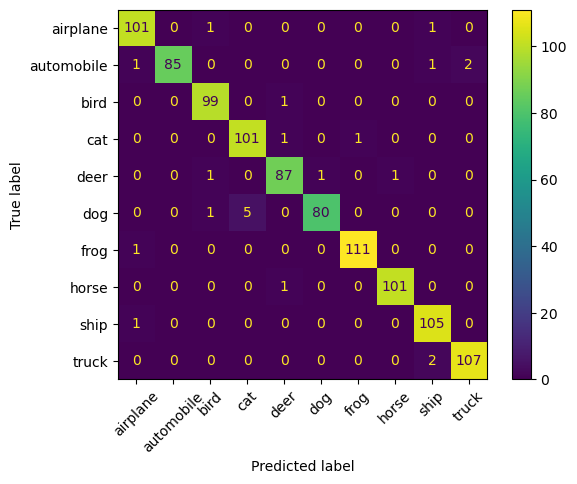

In [221]:
labels = trainds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)